In [80]:
# -----------------------------------------------------------
# STEP 1: PROJECT SETUP AND LIBRARIES
# -----------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import json
import ast
import os
import warnings
import zipfile as zipfile

warnings.filterwarnings('ignore')


sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

print("Setup complete. Libraries loaded.")

Setup complete. Libraries loaded.


In [81]:
# -----------------------------------------------------------
# STEP 2: DATA LOADING
# -----------------------------------------------------------

try:
    movies_path = 'dsaTermProjectFall25/rawData/tmdb_5000_movies.csv'
    cpi_path = 'dsaTermProjectFall25/rawData/US CPI.csv'
    unemp_path = 'dsaTermProjectFall25/rawData/UNRATE.csv'
    holiday_path = 'dsaTermProjectFall25/rawData/US Holiday Dates (2004-2021).csv'
    credits_path = 'dsaTermProjectFall25/rawData/tmdb_5000_credits.csv.zip'
    oscar_path = 'dsaTermProjectFall25/rawData/the_oscar_award.csv'

    df_movies = pd.read_csv(movies_path)
    CREDITS_FILE_IN_ZIP = 'tmdb_5000_credits.csv'
    with zipfile.ZipFile(credits_path, 'r') as z:
        df_credits = pd.read_csv(z.open(CREDITS_FILE_IN_ZIP))
    df_cpi = pd.read_csv(cpi_path)
    df_unrate = pd.read_csv(unemp_path)
    df_holidays = pd.read_csv(holiday_path)
    df_oscars = pd.read_csv(oscar_path)

    print("STATUS: All raw datasets loaded successfully.")

except FileNotFoundError as e:
    print(f"FATAL ERROR: One or more files not found. Check filenames in 'rawData'.")
    print(f"Error Detail: {e}")
    raise

STATUS: All raw datasets loaded successfully.


In [86]:
# -----------------------------------------------------------
# STEP 3: DATA CLEANING & MERGING
# -----------------------------------------------------------


# 1. Merge Movies and Credits
df_movies.rename(columns={'id': 'movie_id', 'title': 'title_x'}, inplace=True)
df_main = df_movies.merge(df_credits, on='movie_id')

# 2. Rename Conflicting Column
df_main.rename(columns={'title_x': 'Title'}, inplace=True)

# 3. Date Conversion & Filtering
DATE_COL = 'release_date'
df_main[DATE_COL] = pd.to_datetime(df_main[DATE_COL], errors='coerce')
df_main['Year'] = df_main[DATE_COL].dt.year

# Filter: 2010-2024 & Valid Financials
df_main = df_main[
    (df_main['Year'] >= 2010) &
    (df_main['budget'] > 1000) &
    (df_main['revenue'] > 1000)
].copy()


def get_top_cast(x):
    try:
        data = ast.literal_eval(x) if isinstance(x, str) else x
        names = [d['name'] for d in data]
        return names[:3] if len(names) >= 3 else names
    except:
        return []

def get_director(x):
    try:
        data = ast.literal_eval(x) if isinstance(x, str) else x
        for d in data:
            if d['job'] == 'Director':
                return d['name']
        return np.nan
    except:
        return np.nan

df_main['Top_Cast'] = df_main['cast'].apply(get_top_cast)
df_main['Director'] = df_main['crew'].apply(get_director)


def clean_json_display(x):
    try:
        data = ast.literal_eval(x) if isinstance(x, str) else x
        if isinstance(data, list):
            return ", ".join([d['name'] for d in data])
        return ""
    except:
        return x


df_main['genres'] = df_main['genres'].apply(clean_json_display)
df_main['production_companies'] = df_main['production_companies'].apply(clean_json_display)


print(f"Merging & Cleaning Complete. Dataset Size: {df_main.shape}")
print("\n")


display_cols = [
    'Title', 'Year', 'Director', 'Top_Cast',
    'budget', 'revenue', 'vote_average', 'genres'
]

from IPython.display import display
display(df_main[display_cols].head(20))

Merging & Cleaning Complete. Dataset Size: (945, 26)




,Title,Year,Director,Top_Cast,budget,revenue,vote_average,genres
2,Spectre,2015.0,Sam Mendes,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",245000000,880674609,6.3,"Action, Adventure, Crime"
3,The Dark Knight Rises,2012.0,Christopher Nolan,"[Christian Bale, Michael Caine, Gary Oldman]",250000000,1084939099,7.6,"Action, Crime, Drama, Thriller"
4,John Carter,2012.0,Andrew Stanton,"[Taylor Kitsch, Lynn Collins, Samantha Morton]",260000000,284139100,6.1,"Action, Adventure, Science Fiction"
6,Tangled,2010.0,Byron Howard,"[Zachary Levi, Mandy Moore, Donna Murphy]",260000000,591794936,7.4,"Animation, Family"
7,Avengers: Age of Ultron,2015.0,Joss Whedon,"[Robert Downey Jr., Chris Hemsworth, Mark Ruff...",280000000,1405403694,7.3,"Action, Adventure, Science Fiction"
9,Batman v Superman: Dawn of Justice,2016.0,Zack Snyder,"[Ben Affleck, Henry Cavill, Gal Gadot]",250000000,873260194,5.7,"Action, Adventure, Fantasy"
13,The Lone Ranger,2013.0,Gore Verbinski,"[Johnny Depp, Armie Hammer, William Fichtner]",255000000,89289910,5.9,"Action, Adventure, Western"
14,Man of Steel,2013.0,Zack Snyder,"[Henry Cavill, Amy Adams, Michael Shannon]",225000000,662845518,6.5,"Action, Adventure, Fantasy, Science Fiction"
16,The Avengers,2012.0,Joss Whedon,"[Robert Downey Jr., Chris Evans, Mark Ruffalo]",220000000,1519557910,7.4,"Science Fiction, Action, Adventure"
17,Pirates of the Caribbean: On Stranger Tides,2011.0,Rob Marshall,"[Johnny Depp, Penélope Cruz, Ian McShane]",380000000,1045713802,6.4,"Adventure, Action, Fantasy"


In [87]:
# -----------------------------------------------------------
# STEP 4: ENRICHMENT
# -----------------------------------------------------------

# --- A. STAR PRESTIGE INDEX (Using Oscar Data) ---
print("... Calculating Star Prestige Index ...")

# 1. Clean Oscar Data
# Filter only winners or significant categories if needed. Here we count wins.
df_oscars['winner'] = df_oscars['winner'].astype(int)
oscar_wins = df_oscars[df_oscars['winner'] == 1]

# Create a lookup dictionary: Name -> Year of Award
# We want to know WHEN they won to avoid look-ahead bias
award_history = []
for idx, row in oscar_wins.iterrows():
    award_history.append({'name': row['name'], 'year': row['year_ceremony']})
df_award_history = pd.DataFrame(award_history)

def calculate_prestige(row):
    score = 0
    release_year = row['Year']

    # Check Director Score
    director = row['Director']
    if director:
        # Count awards won BEFORE the movie release
        past_wins = df_award_history[
            (df_award_history['name'] == director) &
            (df_award_history['year'] < release_year)
        ].shape[0]
        score += (past_wins * 3) # Directors weight more (example weight)

    # Check Cast Score
    for actor in row['Top_Cast']:
        past_wins = df_award_history[
            (df_award_history['name'] == actor) &
            (df_award_history['year'] < release_year)
        ].shape[0]
        score += past_wins # 1 point per actor win

    return score

df_main['Star_Prestige_Index'] = df_main.apply(calculate_prestige, axis=1)
print("-> Star Prestige Index calculated.")


# --- B. INFLATION ADJUSTMENT ---
if 'Year' not in df_cpi.columns:
    # Assuming format like '01-01-1913' or similar in 'Yearmon'
    df_cpi['Year'] = pd.to_datetime(df_cpi['Yearmon'], dayfirst=True, errors='coerce').dt.year
    # If conversion failed, try standard format
    if df_cpi['Year'].isnull().all():
         df_cpi['Year'] = pd.to_datetime(df_cpi['Yearmon'], errors='coerce').dt.year

cpi_yearly = df_cpi.groupby('Year')['CPI'].mean().reset_index()
df_main = df_main.merge(cpi_yearly, on='Year', how='left')

# Adjust to 2024 dollars (approx CPI ~310)
current_cpi = cpi_yearly['CPI'].max()
df_main['Real_Budget'] = df_main['budget'] * (current_cpi / df_main['CPI'])
df_main['Real_Revenue'] = df_main['revenue'] * (current_cpi / df_main['CPI'])
print("-> Inflation Adjustment completed.")


# --- C. UNEMPLOYMENT RATE ---
if 'Year' not in df_unrate.columns:
    df_unrate['Year'] = pd.to_datetime(df_unrate['observation_date']).dt.year

unrate_yearly = df_unrate.groupby('Year')['UNRATE'].mean().reset_index()
df_main = df_main.merge(unrate_yearly, on='Year', how='left')
print("-> Unemployment Data merged.")


# --- D. SEASONALITY (HOLIDAY) ---
df_holiday['Date'] = pd.to_datetime(df_holiday['Date'])
holiday_list = df_holiday['Date'].tolist()

def is_holiday(date):
    if pd.isnull(date): return 0
    for h in holiday_list:
        if abs((h - date).days) <= 7: # 1 week window
            return 1
    return 0

df_main['Is_Holiday'] = df_main['release_date'].apply(is_holiday)
print("-> Seasonality Flag created.")

df_final = df_main.copy()

... Calculating Star Prestige Index ...
-> Star Prestige Index calculated.
-> Inflation Adjustment completed.
-> Unemployment Data merged.
-> Seasonality Flag created.


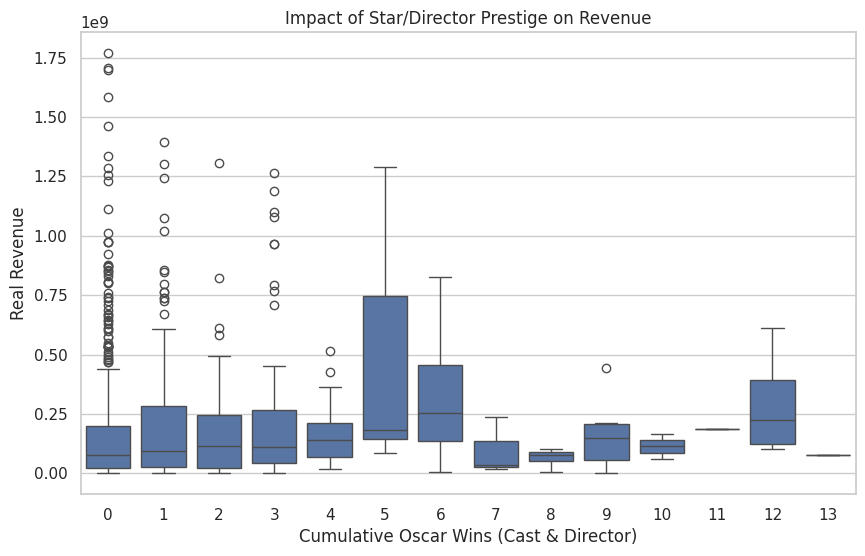

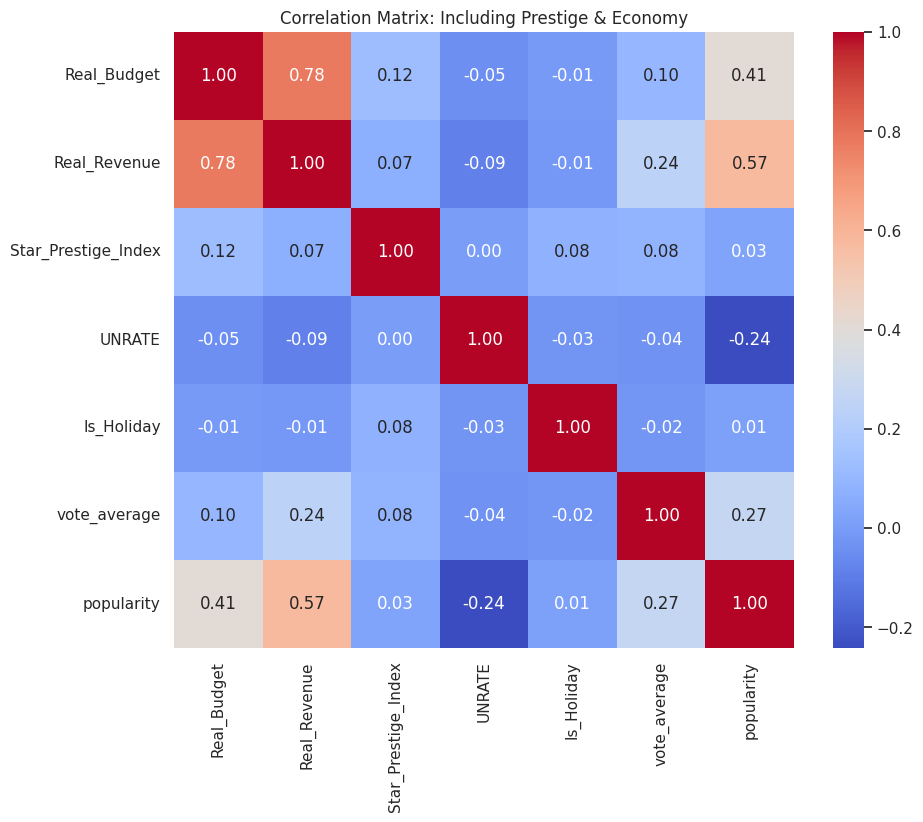

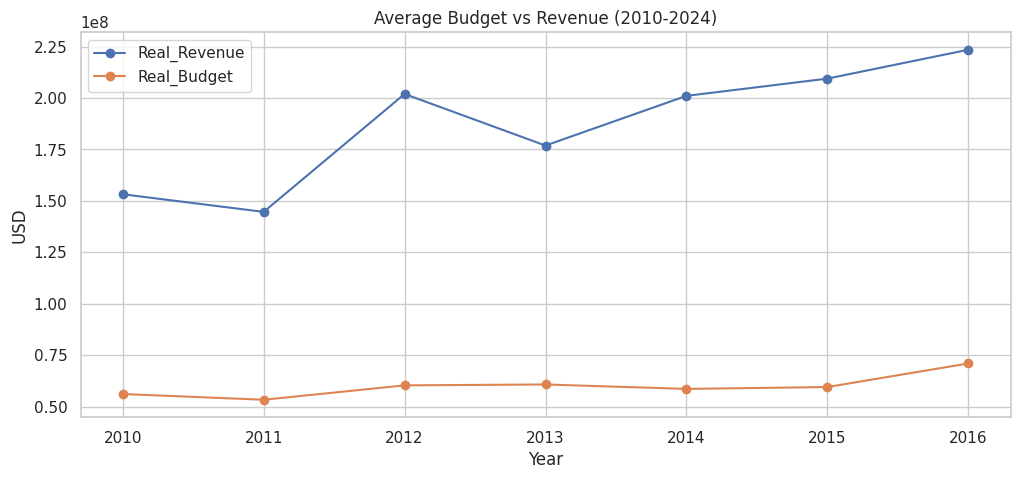

In [88]:
# -----------------------------------------------------------
# STEP 5: EXPLORATORY DATA ANALYSIS
# -----------------------------------------------------------

# 1. Star Prestige vs Revenue
plt.figure(figsize=(10, 6))
sns.boxplot(x='Star_Prestige_Index', y='Real_Revenue', data=df_final)
plt.title('Impact of Star/Director Prestige on Revenue')
plt.xlabel('Cumulative Oscar Wins (Cast & Director)')
plt.ylabel('Real Revenue')
plt.show()
print("\n\n\n")

# 2. Correlation Matrix (All Factors)
corr_cols = ['Real_Budget', 'Real_Revenue', 'Star_Prestige_Index', 'UNRATE', 'Is_Holiday', 'vote_average', 'popularity']
plt.figure(figsize=(10, 8))
sns.heatmap(df_final[corr_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix: Including Prestige & Economy')
plt.show()
print("\n\n\n")

# 3. Time Series Trend
yearly_trend = df_final.groupby('Year')[['Real_Revenue', 'Real_Budget']].mean()
yearly_trend.plot(kind='line', marker='o', figsize=(12, 5), title="Average Budget vs Revenue (2010-2024)")
plt.ylabel("USD")
plt.show()
print("\n\n\n")

>>> HYPOTHESIS TEST RESULTS <<<

--- [H1] Economic Context (Unemployment vs Revenue) ---
Pearson Correlation: -0.0896
>> RESULT: Not Supported/Weak.


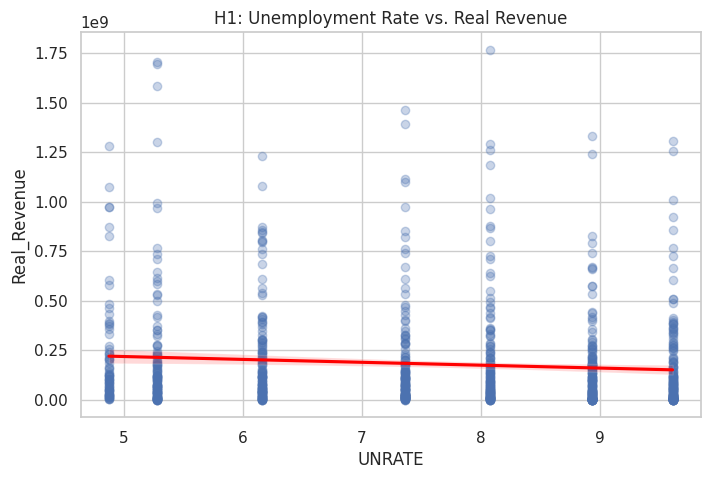


--- [H2] Star Prestige Effect (Awards vs Revenue) ---
Avg Revenue (Stars Present): $223,737,922
Avg Revenue (No Stars): $164,831,676
P-Value: 0.00375
>> RESULT: Supported! Movies with prior Oscar winners earn significantly more.


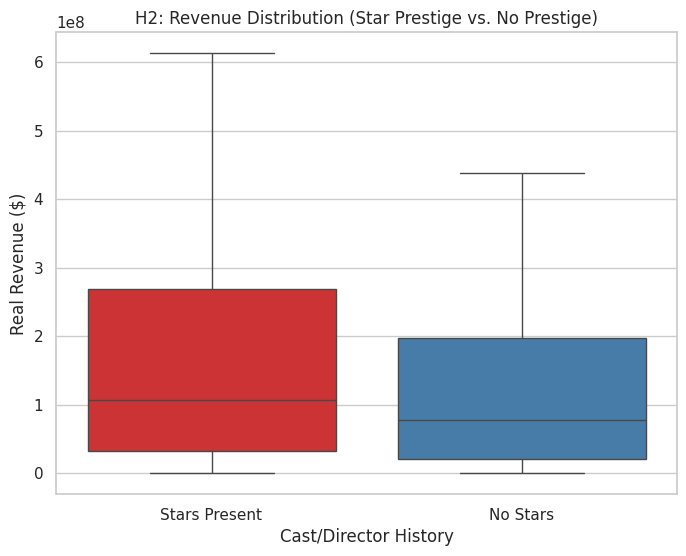


--- [H3] Holiday Effect Analysis ---
Avg Revenue (Holiday): $178,131,684
Avg Revenue (Regular): $185,715,131
P-Value: 0.65738
>> RESULT: Not Supported.


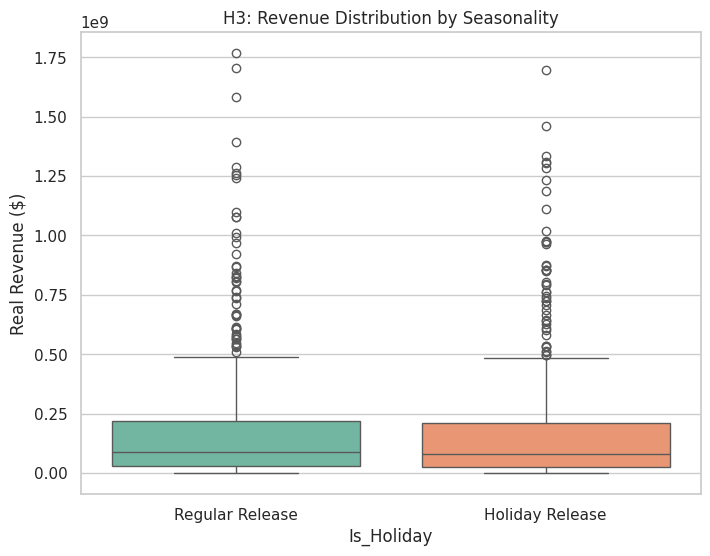


--- [H4] Genre Effect Analysis (ANOVA) ---
Groups Tested: ['Action', 'Comedy', 'Drama', 'Science Fiction', 'Adventure']
F-Statistic: 57.3749
P-Value: 0.00000
>> RESULT: Supported! Revenue difference among these top genres is STATISTICALLY SIGNIFICANT.


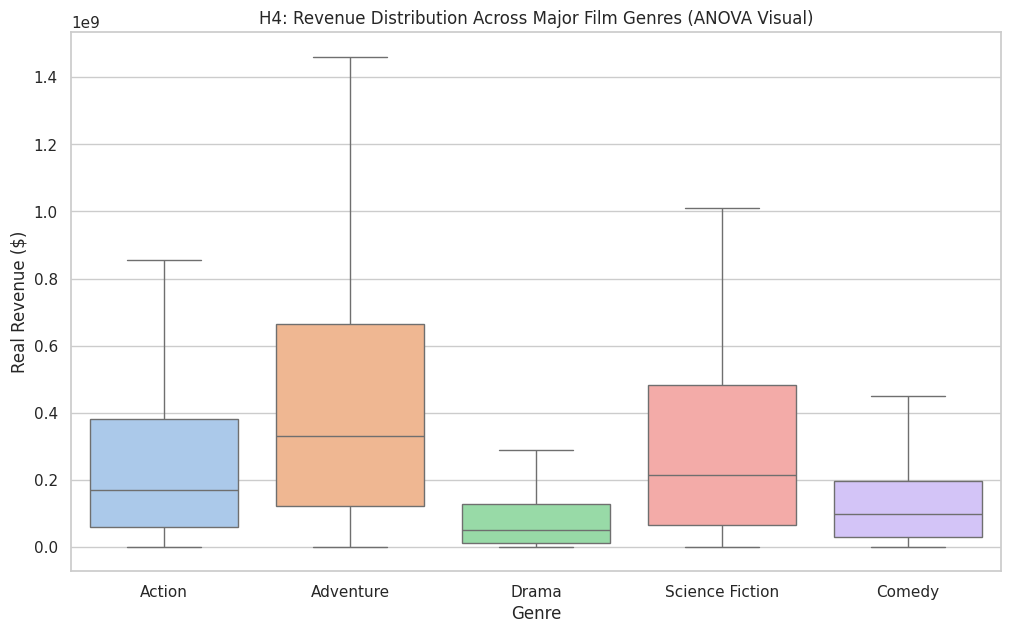


>>> ALL HYPOTHESES HAVE BEEN TESTED AND VISUALIZED. <<<


In [89]:
# -----------------------------------------------------------
# HYPOTHESIS TESTING
# -----------------------------------------------------------

print(">>> HYPOTHESIS TEST RESULTS <<<\n")
df_final['Has_Prestige'] = df_final['Star_Prestige_Index'].apply(lambda x: 'Stars Present' if x > 0 else 'No Stars')


# TEST 1: ECONOMIC FACTORS (H1)
print("--- [H1] Economic Context (Unemployment vs Revenue) ---")
corr_unemp = df_final['UNRATE'].corr(df_final['Real_Revenue'])
print(f"Pearson Correlation: {corr_unemp:.4f}")

if corr_unemp < -0.1: print(">> RESULT: Supported (Negative Correlation).")
else: print(">> RESULT: Not Supported/Weak.")

# Visualization H1: Regplot (Shows Correlation and Trendline)
plt.figure(figsize=(8, 5))
sns.regplot(x='UNRATE', y='Real_Revenue', data=df_final, scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.title('H1: Unemployment Rate vs. Real Revenue')
plt.show()



# TEST 2: STAR PRESTIGE EFFECT (H2)
print("\n--- [H2] Star Prestige Effect (Awards vs Revenue) ---")

# T-Test preparation
with_stars = df_final[df_final['Star_Prestige_Index'] > 0]['Real_Revenue'].dropna()
no_stars = df_final[df_final['Star_Prestige_Index'] == 0]['Real_Revenue'].dropna()
t_stat_stars, p_val_stars = stats.ttest_ind(with_stars, no_stars, equal_var=False)

print(f"Avg Revenue (Stars Present): ${with_stars.mean():,.0f}")
print(f"Avg Revenue (No Stars): ${no_stars.mean():,.0f}")
print(f"P-Value: {p_val_stars:.5f}")

if p_val_stars < 0.05:
    print(">> RESULT: Supported! Movies with prior Oscar winners earn significantly more.")
else:
    print(">> RESULT: Not Supported.")

# Visualization H2: Box Plot (Visual proof for T-Test)
plt.figure(figsize=(8, 6))
sns.boxplot(x='Has_Prestige', y='Real_Revenue', data=df_final, palette='Set1', showfliers=False)
plt.title('H2: Revenue Distribution (Star Prestige vs. No Prestige)')
plt.xlabel('Cast/Director History')
plt.ylabel('Real Revenue ($)')
plt.show()


# TEST 3: HOLIDAY EFFECT (H3)
print("\n--- [H3] Holiday Effect Analysis ---")
holiday_rev = df_final[df_final['Is_Holiday'] == 1]['Real_Revenue'].dropna()
regular_rev = df_final[df_final['Is_Holiday'] == 0]['Real_Revenue'].dropna()
t_stat_hol, p_val_hol = stats.ttest_ind(holiday_rev, regular_rev, equal_var=False)

print(f"Avg Revenue (Holiday): ${holiday_rev.mean():,.0f}")
print(f"Avg Revenue (Regular): ${regular_rev.mean():,.0f}")
print(f"P-Value: {p_val_hol:.5f}")

if p_val_hol < 0.05:
    print(">> RESULT: Supported! Holiday releases earn significantly more.")
else:
    print(">> RESULT: Not Supported.")

# Visualization H3: Box Plot (Visual proof for T-Test)
plt.figure(figsize=(8, 6))
sns.boxplot(x='Is_Holiday', y='Real_Revenue', data=df_final, palette='Set2')
plt.xticks([0, 1], ['Regular Release', 'Holiday Release'])
plt.title('H3: Revenue Distribution by Seasonality')
plt.ylabel('Real Revenue ($)')
plt.show()



# TEST 4: CATEGORICAL ANALYSIS (H4 - GENRE EFFECT)
# Method: One-Way ANOVA Test
print("\n--- [H4] Genre Effect Analysis (ANOVA) ---")


df_genres_exploded = df_final.assign(Genre=df_final['genres'].str.split(', ')).explode('Genre')
df_genres_exploded['Genre'] = df_genres_exploded['Genre'].str.strip()
df_filtered_genres = df_genres_exploded[df_genres_exploded['Genre'] != '']

# 2. Select Top Groups for comparison
top_genres = ['Action', 'Comedy', 'Drama', 'Science Fiction', 'Adventure']
genre_groups = []
for genre in top_genres:
    revenue_data = df_filtered_genres[df_filtered_genres['Genre'] == genre]['Real_Revenue'].dropna()
    genre_groups.append(revenue_data)

# 3. Perform ANOVA Test
try:
    if all(len(g) >= 2 for g in genre_groups):
        f_statistic, p_value = stats.f_oneway(*genre_groups)

        print(f"Groups Tested: {top_genres}")
        print(f"F-Statistic: {f_statistic:.4f}")
        print(f"P-Value: {p_value:.5f}")

        if p_value < 0.05:
            print(">> RESULT: Supported! Revenue difference among these top genres is STATISTICALLY SIGNIFICANT.")
        else:
            print(">> RESULT: Not supported. Mean revenues are statistically similar.")
except Exception as e:
    print(f"Error during ANOVA: {e}. Check if all required genre groups had sufficient data.")

# 4. Visualization (ANOVA Box Plot)
plt.figure(figsize=(12, 7))
sns.boxplot(x='Genre', y='Real_Revenue', data=df_filtered_genres[df_filtered_genres['Genre'].isin(top_genres)], palette='pastel', showfliers=False)
plt.title('H4: Revenue Distribution Across Major Film Genres (ANOVA Visual)')
plt.ylabel('Real Revenue ($)')
plt.show()

print("\n>>> ALL HYPOTHESES HAVE BEEN TESTED AND VISUALIZED. <<<")